In [1]:
!pip install einops
!pip install vit_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 518.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.6/117.6 kB 961.8 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-man

In [2]:
import zipfile
import io
import os
import shutil
import csv

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models, datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, multilabel_confusion_matrix

import torchaudio
from einops.layers.torch import Rearrange
from einops import rearrange
from vit_pytorch import ViT

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load Data

In [5]:
# unzip folder w/ data
!unzip "/content/drive/MyDrive/University_of_Toronto/Year_4/CSC413_Project/MFCC_augmented_last_split.zip"

Streaming output truncated to the last 5000 lines.
 extracting: train/Pine Siskin_160189_seg_38.wav+Marsh Wren_158975_seg_13.wav.png  
 extracting: train/Anna's Hummingbird_159875_seg_3.wav+Pine Siskin_159015_seg_41.wav.png  
 extracting: train/Red-breasted Nuthatch_159321_seg_74.wav+Golden-crowned Sparrow_159724_seg_69.wav.png  
 extracting: train/Bewick's Wren_159376_seg_3.wav+Pine Siskin_160113_seg_8.wav.png  
 extracting: train/Anna's Hummingbird_160046_seg_21.wav+Red-breasted Nuthatch_159329_seg_11.wav.png  
 extracting: train/Pine Siskin_159015_seg_41.wav+Red-breasted Nuthatch_159291_seg_8.wav.png  
 extracting: train/Spotted Towhee_160228_seg_1.wav+Marsh Wren_685677_seg_7.wav.png  
 extracting: train/Song Sparrow_661913_seg_8.wav+Red-winged Blackbird_160102_seg_1.wav.png  
 extracting: train/White-crowned Sparrow_558111_seg_15.wav+Red-breasted Nuthatch_159157_seg_70.wav.png  
 extracting: train/White-crowned Sparrow_160176_seg_28.wav+Spotted Towhee_661084_seg_7.wav.png  
 extrac

In [6]:
class BirdDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.csv_file = f'{data_dir}/{data_dir.split("/")[-1]}.csv'
        self.transform = transform
        self.img_labels, self.label_map = self._get_image_labels_and_map()

    def _get_image_labels_and_map(self):
        # load CSV file
        df = pd.read_csv(self.csv_file)

        # extract filenames and bird names
        img_labels = list(zip(df['filename'], zip(df['label1'], df['label2'])))

        # create a set of unique bird names
        label_set = set(df['label1']).union(set(df['label2']))

        # create a map of bird names to indices
        label_map = {label: idx for idx, label in enumerate(sorted(label_set))}
        print(label_map)

        # convert labels to one-hot encoding
        mlb = MultiLabelBinarizer(classes=sorted(label_set))
        one_hot_encoded_labels = mlb.fit_transform(df[['label1', 'label2']].values)
        one_hot_encoded_labels = [torch.tensor(labels) for labels in one_hot_encoded_labels]

        return list(zip(df['filename'], one_hot_encoded_labels)), label_map

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name, one_hot_labels = self.img_labels[idx]
        img_path = os.path.join(self.data_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, one_hot_labels

In [7]:
# define data directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'
batch_size = 32

# define transformation sequence
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# load and transform the dataset
def load_data(data_dir, batch_size, transform):
    dataset = BirdDataset(data_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

dataloaders = {
    'train': load_data(train_data_dir, batch_size, transform),
    'test': load_data(test_data_dir, batch_size, transform),
}

{"Anna's Hummingbird": 0, "Bewick's Wren": 1, 'Golden-crowned Sparrow': 2, 'Marsh Wren': 3, 'Pine Siskin': 4, 'Red-breasted Nuthatch': 5, 'Red-winged Blackbird': 6, 'Song Sparrow': 7, 'Spotted Towhee': 8, 'White-crowned Sparrow': 9}
{"Anna's Hummingbird": 0, "Bewick's Wren": 1, 'Golden-crowned Sparrow': 2, 'Marsh Wren': 3, 'Pine Siskin': 4, 'Red-breasted Nuthatch': 5, 'Red-winged Blackbird': 6, 'Song Sparrow': 7, 'Spotted Towhee': 8, 'White-crowned Sparrow': 9}


Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32, 10])


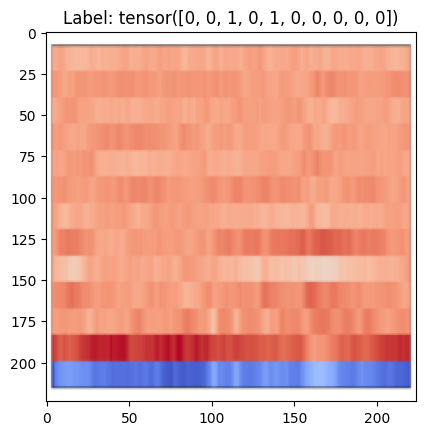

In [8]:
# example: print shapes and visualize first batch
dataiter = iter(dataloaders['train'])
images, labels = next(dataiter)

print(f'Batch shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

# visualize an image from the batch
plt.imshow(images[0].permute(1, 2, 0))    # image tensor is (C, H, W) and needs to be (H, W, C)
plt.title(f'Label: {labels[0]}')
plt.show()

# Initialize Model

Reference links for the ViT module from torchvision.models:

https://pytorch.org/vision/stable/models/vision_transformer.html

https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py


In [9]:
# define the ViT model architecture
class ViTAudio(nn.Module):
    def __init__(self, num_classes):
        super(ViTAudio, self).__init__()
        self.vit = ViT(
            image_size=(224, 224),
            patch_size=16,
            num_classes=num_classes,
            dim=512,                    # transformer hidden dimension
            depth=6,                    # num transformer layers
            heads=8,                    # num attention heads
            mlp_dim=1024,               # dim of the feedforward network
            dropout=0.1,
        )

    def forward(self, x):
        return self.vit(x)

In [10]:
# initialize the ViT model to data specifications
num_classes = len(dataloaders['train'].dataset.label_map) # number unique labels in dataset

model = ViTAudio(num_classes)
model.to(device)

ViTAudio(
  (vit): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
      (1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=768, out_features=512, bias=True)
      (3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (transformer): Transformer(
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-5): 6 x ModuleList(
          (0): Attention(
            (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.1, inplace=False)
            (to_qkv): Linear(in_features=512, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=512, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        

We will load the pretrained weights of Facebook's Wav2Vec2-Base: https://huggingface.co/facebook/wav2vec2-base

(This ended up not happening as the inputs don't match)

# Train Model

In [11]:
# loss function for multilabel classification -- binary cross entropy loss w logits
criterion = nn.BCEWithLogitsLoss()

# optimizer -- adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# training function
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

# training loop
def train_loop(model, dataloaders, criterion, optimizer, device, num_epochs=10):
    train_losses = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_loss = train(model, dataloaders['train'], criterion, optimizer, device)
        train_losses.append(train_loss)
        print(f"Training Loss: {train_loss:.4f}")

    return train_losses

In [50]:
train_losses = train_loop(model, dataloaders, criterion, optimizer, device, num_epochs=5)

Epoch 1/5


Training: 100%|██████████| 568/568 [04:45<00:00,  1.99it/s]


Training Loss: 0.7471
Epoch 2/5


Training: 100%|██████████| 568/568 [04:54<00:00,  1.93it/s]


Training Loss: 0.7470
Epoch 3/5


Training: 100%|██████████| 568/568 [05:01<00:00,  1.88it/s]


Training Loss: 0.7471
Epoch 4/5


Training: 100%|██████████| 568/568 [04:44<00:00,  2.00it/s]


Training Loss: 0.7471
Epoch 5/5


Training: 100%|██████████| 568/568 [04:43<00:00,  2.00it/s]

Training Loss: 0.7472


In [51]:
# save the trained model
torch.save(model.state_dict(), 'vit_model.pth')

In [53]:
torch.save(model,'/content/drive/MyDrive/University_of_Toronto/Year_4/CSC413_Project/vit_model.pt')

# Evaluate Model

In [13]:
model = ViTAudio(num_classes)
model.load_state_dict(torch.load('vit_model.pth'))
model.eval()

ViTAudio(
  (vit): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
      (1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=768, out_features=512, bias=True)
      (3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (transformer): Transformer(
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-5): 6 x ModuleList(
          (0): Attention(
            (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.1, inplace=False)
            (to_qkv): Linear(in_features=512, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=512, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        

In [14]:
# make predictions on the test dataset
def predict_multilabel(model, dataloader):
    device = next(model.parameters()).device

    y_true = []
    y_pred_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted_probs = torch.sigmoid(outputs)  # outputs are logits, so apply sigmoid for probabilities
            y_true.extend(labels.cpu().numpy())
            y_pred_probs.extend(predicted_probs.cpu().numpy())
    return np.array(y_true), np.array(y_pred_probs)

In [15]:
y_true, y_pred_probs = predict_multilabel(model, dataloaders['test'])

In [16]:
# get binary predictions for classes
threshold = 0.5
y_pred_binary = (y_pred_probs > threshold).astype(int)

In [17]:
# precision
precision_micro = precision_score(y_true, y_pred_binary, average='micro')
precision_macro = precision_score(y_true, y_pred_binary, average='macro')

# recall
recall_micro = recall_score(y_true, y_pred_binary, average='micro')
recall_macro = recall_score(y_true, y_pred_binary, average='macro')

# F1 score
f1_micro = 2 * (precision_micro * recall_micro) / (precision_micro + recall_micro)
f1_macro = 2 * (precision_macro * recall_macro) / (precision_macro + recall_macro)

# AUC
auc_micro = roc_auc_score(y_true, y_pred_probs, average='micro')
auc_macro = roc_auc_score(y_true, y_pred_probs, average='macro')

print("Precision (Micro):", precision_micro)
print("Precision (Macro):", precision_macro)
print("Recall (Micro):", recall_micro)
print("Recall (Macro):", recall_macro)
print("F1 Score (Micro):", f1_micro)
print("F1 Score (Macro):", f1_macro)
print("AUC (Micro):", auc_micro)
print("AUC (Macro):", auc_macro)

Precision (Micro): 0.20222906584543188
Precision (Macro): 0.11066006600660065
Recall (Micro): 0.3034103410341034
Recall (Macro): 0.3000846023688663
F1 Score (Micro): 0.2426962337205209
F1 Score (Macro): 0.16169355057993334
AUC (Micro): 0.5069573728549973
AUC (Macro): 0.4999415600154718


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


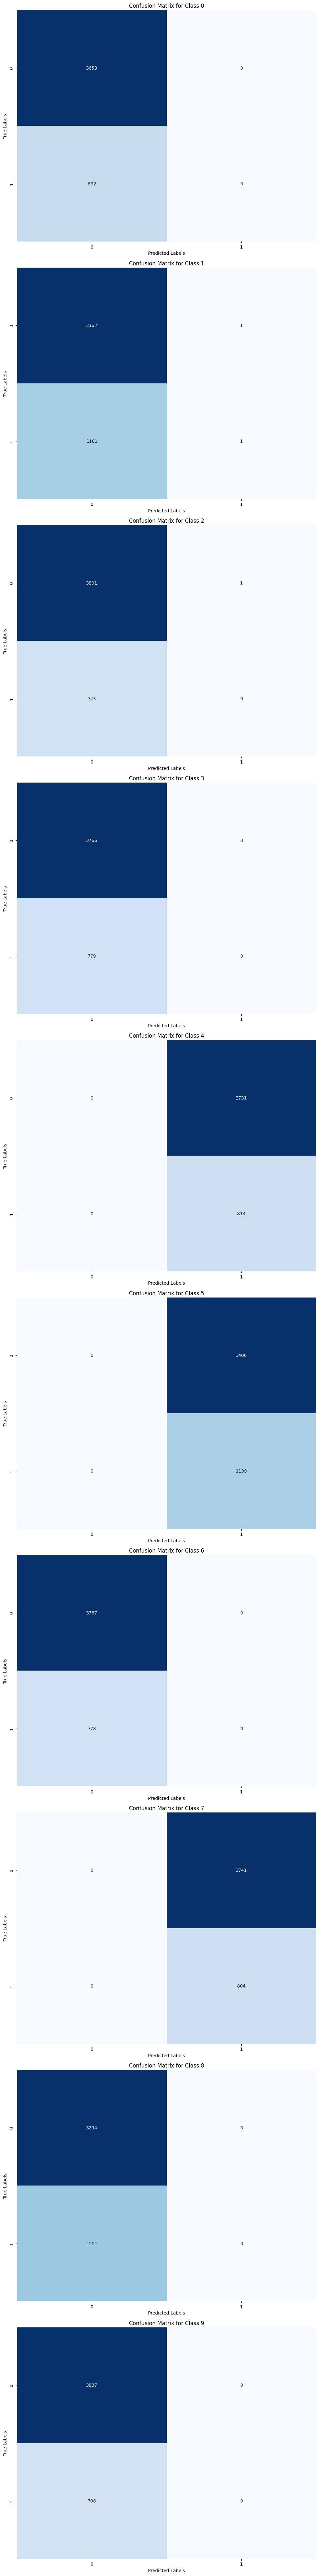

In [20]:
# multilabel confusion matrix
multilabel_conf_matrix = multilabel_confusion_matrix(y_true, y_pred_binary)

# plot confusion matrices
num_classes = multilabel_conf_matrix.shape[0]
fig, axes = plt.subplots(num_classes, 1, figsize=(10, 8*num_classes))

for i in range(num_classes):
    sns.heatmap(multilabel_conf_matrix[i], annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])
    axes[i].set_title(f"Confusion Matrix for Class {i}")
    axes[i].set_xlabel("Predicted Labels")
    axes[i].set_ylabel("True Labels")

plt.tight_layout()
plt.show()

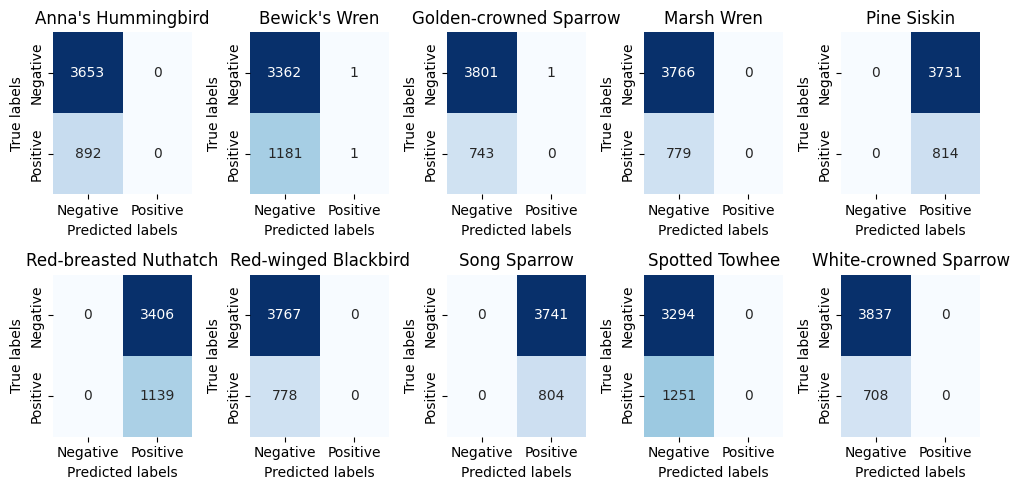

In [18]:
labels = {
    "Anna's Hummingbird": [[3653, 0], [892, 0]],
    "Bewick's Wren": [[3362, 1], [1181, 1]],
    'Golden-crowned Sparrow': [[3801, 1], [743, 0]],
    'Marsh Wren': [[3766, 0], [779, 0]],
    'Pine Siskin': [[0, 3731], [0, 814]],
    'Red-breasted Nuthatch': [[0, 3406], [0, 1139]],
    'Red-winged Blackbird': [[3767, 0], [778, 0]],
    'Song Sparrow': [[0, 3741], [0, 804]],
    'Spotted Towhee': [[3294, 0], [1251, 0]],
    'White-crowned Sparrow': [[3837, 0], [708, 0]]
}

# Setting up the figure and axes again for confusion matrices
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
axs = axs.flatten()  # Flatten the grid into a list for easier access

# Plot each confusion matrix again
for i, (bird, matrix) in enumerate(labels.items()):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axs[i], cbar=False)
    axs[i].set_title(f'{bird}')
    axs[i].set_xlabel('Predicted labels')
    axs[i].set_ylabel('True labels')
    axs[i].set_xticklabels(['Negative', 'Positive'])
    axs[i].set_yticklabels(['Negative', 'Positive'])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('/content/dcnn_cm.pdf', format='pdf', dpi=600)
plt.show()

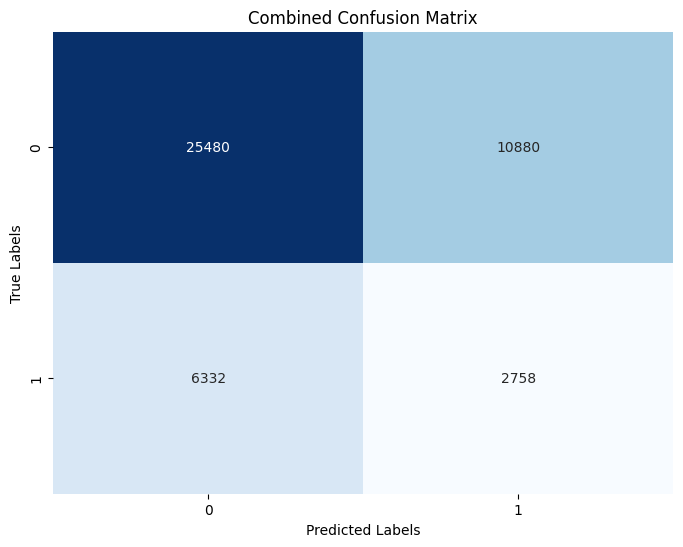

In [21]:
# summing the confusion matrices along the first axis
combined_conf_matrix = np.sum(multilabel_conf_matrix, axis=0)

# plot combined confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(combined_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Combined Confusion Matrix")
plt.show()